# Singular Spectrum Analysis (SSA)
## Задача 20: http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%BF%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F
## Steps: https://en.wikipedia.org/wiki/Singular_spectrum_analysis
## Similar: https://github.com/aj-cloete/pySSA

In [369]:
import numpy as np
from numpy import matrix as m
import pandas as pd
from pandas import DataFrame as df

import scipy.linalg
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

mat = scipy.io.loadmat('C:/Users/va/Downloads/Data_data.mat')
series = pd.Series(map(lambda x: x[0], mat['Data']))

 ### 'Банановые' данные

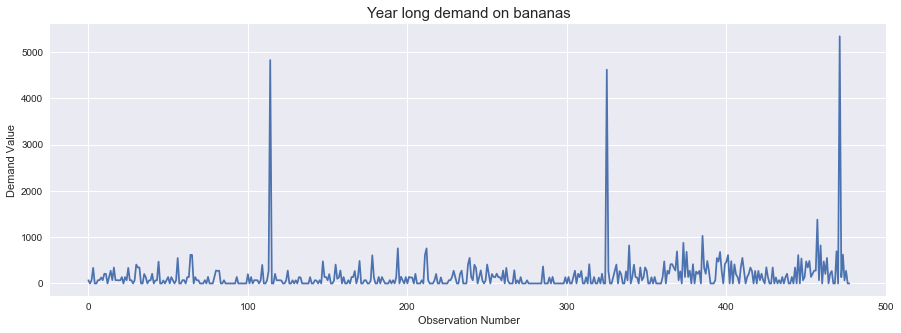

In [383]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

ax.plot(mat['Data']);
ax.set_title('Year long demand on bananas', fontsize=15);
ax.set_ylabel('Demand Value')
ax.set_xlabel('Observation Number');
ax.grid()

### Декомпозиция исходного временного ряда

$S = X \cdot X^T$

$U, s, V = SVD(S)$

$s := \lambda = \sqrt{s}$

$d = rank X$

$V_i = X^T \cdot U_i / \sqrt{\lambda_i} \hspace{1em} i = (1, \dots, d)$

$X_i = \sqrt{\lambda_i} U_i V_i^T$

$\Rightarrow X = X_1 + \dots + X_d$

In [433]:
period = 30
Hankel = scipy.linalg.hankel(series, np.zeros(period)).T[:, :len(series) - period + 1]

X = m(Hankel)
S = X @ X.T
U, s, V = np.linalg.svd(S, full_matrices=True) 
U, s, V = m(U), np.sqrt(s), m(V)
d = np.linalg.matrix_rank(Hankel)

V_ith, X_ith = [], []
for i in range(d):
    V_ith.append(X.T * (U[:,i] / s[i]))
    X_ith.append((s[i] * U[:, i]) * (V_ith[i]).T)
    
Contributions = np.power(s, 2) / np.linalg.norm(X) ** 2  # contribution of each singular value

### Значимость каждого сингулярного значения

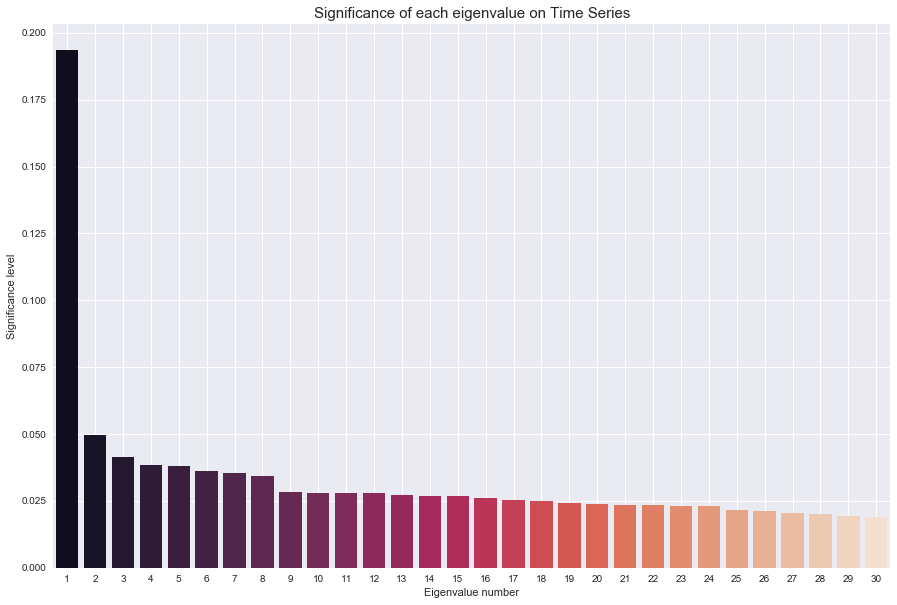

In [434]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10 * 1))

data = Contributions
x = list(range(1, len(data) + 1))
sns.barplot(x, y=data, palette='rocket', ax=ax);  # color=sns.xkcd_rgb['denim blue']
ax.set_title('Significance of each eigenvalue on Time Series', fontsize=15)
ax.set_ylabel('Significance level')
ax.set_xlabel('Eigenvalue number')
ax.grid()
sns.despine(bottom=True, left=True)

# data = np.log(Contributions)
# data = data + max(abs(data))
# data = data / data[0]
# x = list(range(1, len(data) + 1))
# sns.barplot(x, y=data, palette='rocket', ax=ax[1]);  # Blues_r
# ax[1].set_title('Scaled Significance of each eigenvalue on Time Series', fontsize=20)
# ax[1].set_xlabel('Eigenvalue number')
# ax[1].set_ylabel('Scaled Significance level')
# #ax[1].grid()
# sns.despine(bottom=True, left=True)

### Anti-Diagonal Averaging of Hankel Matrix

In [435]:
def AntiDiagonalAveraging(X):
    L, K = X.shape
    minShape, maxShape = min(L, K), max(L, K)

    revived = []

    # Anti Diagonal Averaging
    for k in range(1 - maxShape, minShape):
        # Identity matrix with shifted diagonal to k-th num
        # Rotated clockwise
        # Cut by minShape number of rows
        mask = np.eye(maxShape, k=k, dtype='bool')[::-1][:minShape, :]
        mask_sum = sum(sum(mask))
        masked = np.ma.masked_array(X, mask = 1 - mask)
        revived += [masked.sum() / mask_sum]

    return revived

### Временной ряды, соответствующие самым значимым (top N) сингулярным значениям

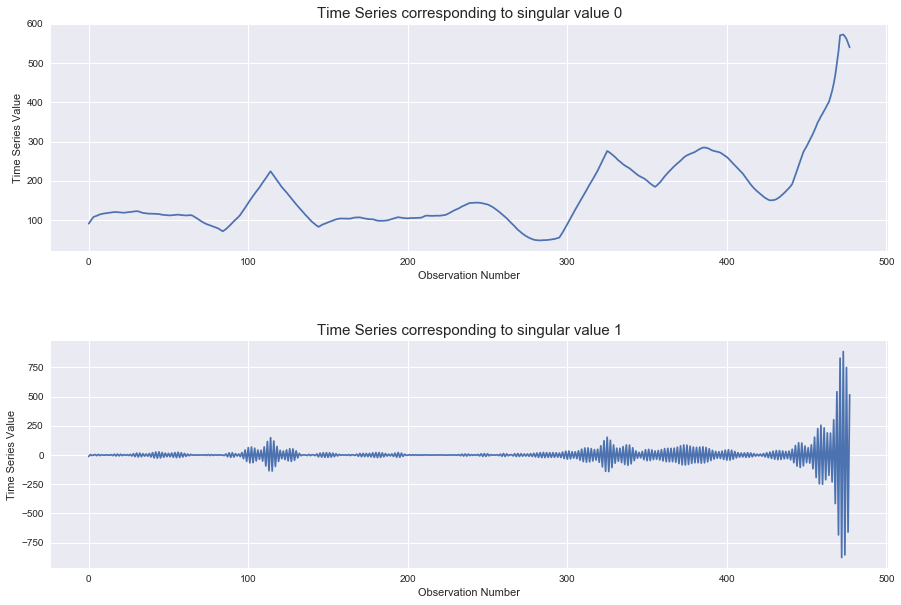

In [436]:
singular_values = 2  # taking top 2 significant singular values

sns.set(style='dark')
fig, ax = plt.subplots(nrows=singular_values, ncols=1, figsize=(15, 5 * singular_values))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # default: 0.2, 0.2

for i in range(singular_values):
    subseries_matrix = X_ith[i]
    subseries = AntiDiagonalAveraging(subseries_matrix)
    if singular_values == 1:
        ax_i = ax
    else:
        ax_i = ax[i]
    ax_i.plot(subseries);
    ax_i.set_title('Time Series corresponding to singular value %d' % (i), fontsize=15);
    ax_i.set_ylabel('Time Series Value');
    ax_i.set_xlabel('Observation Number')
    ax_i.grid()

### Апроксимация исходного временного ряда рядами, соответствующими первым N сингулярным значениям

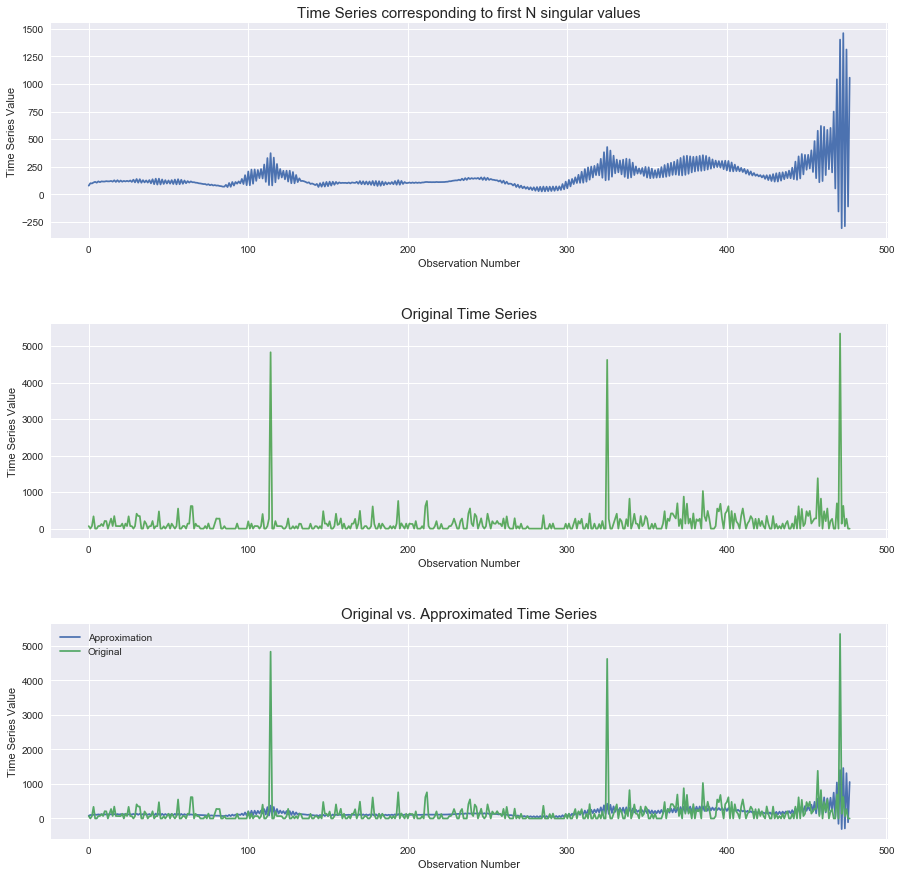

In [437]:
sns.set(style='dark')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 5 * 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # default: 0.2, 0.2

ax[0].plot(AntiDiagonalAveraging(sum([X_ith[i] for i in range(singular_values)])), label='Approximation');
ax[0].set_title('Time Series corresponding to first N singular values', fontsize=15)
ax[0].set_xlabel('Observation Number')
ax[0].set_ylabel('Time Series Value')
ax[0].grid()

ax[1].plot(AntiDiagonalAveraging(X), color='green', alpha=0.6, label='Original');
ax[1].set_title('Original Time Series', fontsize=15)
ax[1].set_xlabel('Observation Number')
ax[1].set_ylabel('Time Series Value')
ax[1].grid()

ax[2].plot(AntiDiagonalAveraging(sum([X_ith[i] for i in range(singular_values)])), label='Approximation');
ax[2].plot(AntiDiagonalAveraging(X), label='Original');
ax[2].legend();
ax[2].set_title('Original vs. Approximated Time Series', fontsize=15)
ax[2].set_xlabel('Observation Number')
ax[2].set_ylabel('Time Series Value');
ax[2].grid()

### Недельное предсказание спроса на бананы

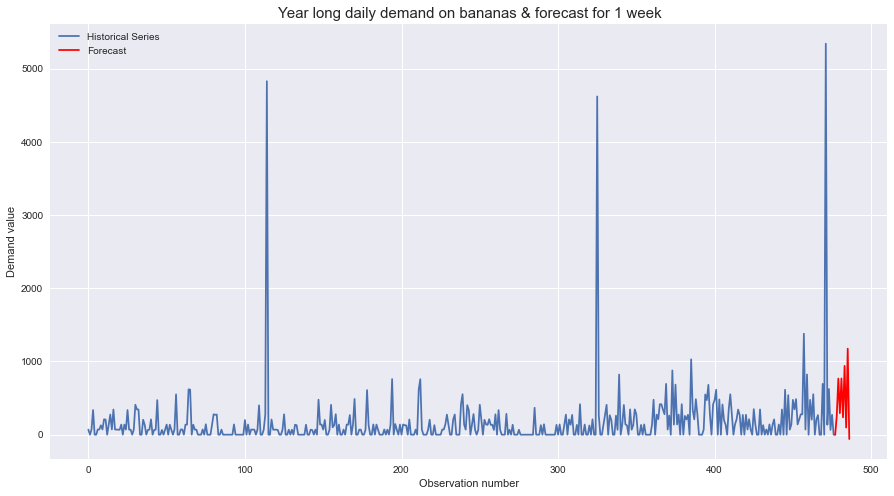

In [438]:
series_values = series.values
series_len = series.shape[0]  # TS len

Orthonormal_base = {i: U[:, i] for i in range(len(Contributions[Contributions > 0]))}  # key i: i-th column of U from SVD
Forecast_orthonormal_base = {}
for i in range(singular_values):
    Forecast_orthonormal_base[i] = Orthonormal_base[i]

X_empty = np.zeros(X.shape)
verticality_coefficient = 0
R = np.zeros(Forecast_orthonormal_base[0].shape)[:-1]
for P in Forecast_orthonormal_base.values():
    X_empty += P * P.T * X
    p = np.ravel(P)[-1]  # transform 1 dim array of 1 elem arrays into 1 dim array and take last value
    verticality_coefficient += p ** 2
    R += p * P[:-1]
R = m(R / (1 - verticality_coefficient))

# Number of predictions given that our data is 1 year long and we seek to predict 1 week foreward
predictions = int(7 * len(series) / 365)
series_forecast = np.ravel(series_values)
for i in range(series_len, series_len + predictions):
    forecast = R.T * m(series_forecast[max(0, i - R.shape[0]) : i]).T  # need max??
    series_forecast = np.append(series_forecast, forecast[0])
    
sns.set(style='dark')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.plot(series_forecast[:series_len], label='Historical Series');
ax.plot(range(series_len - 1, len(series_forecast)), series_forecast[series_len - 1:], color='red', label='Forecast');
ax.set_title('Year long daily demand on bananas & forecast for 1 week', fontsize=15)
ax.set_ylabel('Demand value')
ax.set_xlabel('Observation number')
ax.legend();
ax.grid()

 ## Thanks to aj-cloete (GitHub) for similar work on SSA.
 ### Unfortunately his package 'mySSA' didn't work on my data, so I decided to rewrite code specifically to solve this problem.